# Drowsiness Detection (Team Zesta) via Siamese Convoluted Deep Neural Networks

In [1]:
import cv2 
import os
import numpy as np
from matplotlib import pyplot as plt

In [24]:
import keras
from keras.models import Model, load_model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf

In [25]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

In [22]:
# Making sure of the tensorflow compatibility with the keras API/framework
print("Tensorflow version: " + tf.__version__, "keras version: " + keras.__version__)

Tensorflow version: 2.13.0 keras version: 2.13.1


In [33]:
#Creating necessary directories
if not os.path.exists(os.path.join('data', 'eyes')):
    os.makedirs(os.path.join('data', 'eyes'))
if not os.path.exists(os.path.join('data', 'yawn')):
    os.makedirs(os.path.join('data', 'yawn'))
    
EYE_POS_PATH = os.path.join('data', 'eyes', 'positive')
if not os.path.exists(EYE_POS_PATH):
    os.makedirs(EYE_POS_PATH)

EYE_NEG_PATH = os.path.join('data', 'eyes', 'negative')
if not os.path.exists(EYE_NEG_PATH):
    os.makedirs(EYE_NEG_PATH)

EYE_ANC_PATH = os.path.join('data', 'eyes', 'anchor')
if not os.path.exists(EYE_ANC_PATH):
    os.makedirs(EYE_ANC_PATH)

YAWN_POS_PATH = os.path.join('data', 'yawn', 'positive')
if not os.path.exists(YAWN_POS_PATH):
    os.makedirs(YAWN_POS_PATH)
    
YAWN_NEG_PATH = os.path.join('data', 'yawn', 'negative')
if not os.path.exists(YAWN_NEG_PATH):
    os.makedirs(YAWN_NEG_PATH)

YAWN_ANC_PATH = os.path.join('data', 'yawn', 'anchor')
if not os.path.exists(YAWN_ANC_PATH):
    os.makedirs(YAWN_ANC_PATH)
# Move data into respective folders via GUI

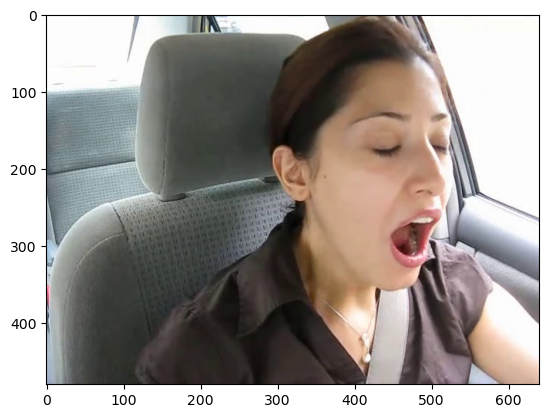

In [71]:
plt.imshow(plt.imread(YAWN_ANC_PATH+"\\1.jpg"))
plt.show()

# Yawn Detection

In [35]:
# Tensorflow data set creation  
yawn_anchor = tf.data.Dataset.list_files(YAWN_ANC_PATH+"\*.jpg").take(300)
yawn_positive = tf.data.Dataset.list_files(YAWN_POS_PATH+'\*.jpg').take(300)
yawn_negative = tf.data.Dataset.list_files(YAWN_NEG_PATH+'\*.jpg').take(300)

In [36]:
# Preprocessing done on 
def read_preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

def read_preprocess_two_simul(img_path1, img_path2, label):
    return (read_preprocess(img_path1), read_preprocess(img_path2), label)

In [37]:
yawn_positives = tf.data.Dataset.zip((yawn_anchor, yawn_positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(yawn_positive)))))
yawn_negatives = tf.data.Dataset.zip((yawn_anchor, yawn_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(yawn_negative)))))
yawn_data = yawn_positives.concatenate(yawn_negatives)

In [38]:
# Build dataloader pipeline
yawn_data = yawn_data.map(read_preprocess_two_simul)
yawn_data = yawn_data.cache()
yawn_data = yawn_data.shuffle(buffer_size=1024)

In [39]:
## Train Test splitting
# Training partition
train_data = yawn_data.take(round(len(yawn_data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = yawn_data.skip(round(len(yawn_data)*.7))
test_data = test_data.take(round(len(yawn_data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [40]:
def make_conv_embedding():
    inp = Input(shape=(105,105,3), name="input_img")
    
    #First Convolution Layer + MaxPooling Layer (glorot-uniform kernel)
    c1 = Conv2D(64, (10,10), activation="relu", strides=(1,1), padding="valid", use_bias=True)(inp)
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)
    
    #2nc
    c2 = Conv2D(128, (7,7), activation="relu", strides=(1,1), padding="valid", use_bias=True)(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    #thrid 
    c3 = Conv2D(128, (4,4), activation="relu", strides=(1,1), padding="valid", use_bias=True)(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    #final
    c4 = Conv2D(256, (4,4), activation="relu", strides=(1,1), padding="valid", use_bias=True)(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [41]:
# Lebesgue 1 norm or manhattan distance b/w outputs
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

def make_siamese():
    embedding = make_conv_embedding()
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(105,105,3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [42]:
siam = make_siamese()

In [43]:
# Adam optimizer and Binary Cross entropy Optimization of parameters
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siam)

In [44]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siam(X, training=True)
        loss = binary_cross_loss(y, yhat)

    grad = tape.gradient(loss, siam.trainable_variables)
    opt.apply_gradients(zip(grad, siam.trainable_variables))

    return loss

def train(data, EPOCHS):
    for epoch in range(0, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+0)

        if epoch % 4 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [77]:
train(train_data, 5)


 Epoch 0/5
 3/27 [==>...........................] - ETA: 5:35

KeyboardInterrupt: 

In [62]:
siam.save('yawn.keras')

In [45]:
model_yawn = load_model('yawn.keras', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

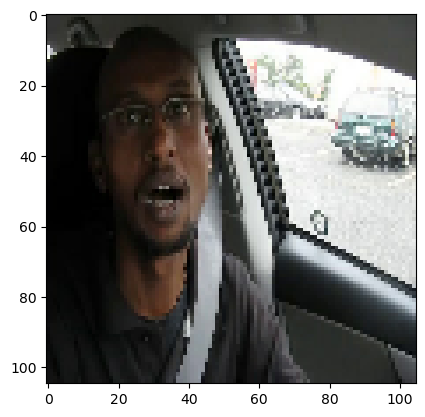

In [52]:
plt.imshow(test_data.as_numpy_iterator().next()[0][0])

In [60]:
testA, testV, y_act = test_data.as_numpy_iterator().next()

In [61]:
model_yawn.predict([testA, testV])

1/1 [==============================] - 1s 1s/step


array([[0.50016385],
       [0.5004773 ],
       [0.5006026 ],
       [0.50067425],
       [0.50148904],
       [0.5010101 ],
       [0.5005012 ],
       [0.4999828 ],
       [0.5001481 ],
       [0.50130546],
       [0.5004936 ],
       [0.5019226 ],
       [0.50052094],
       [0.50093675],
       [0.5016781 ],
       [0.500658  ]], dtype=float32)

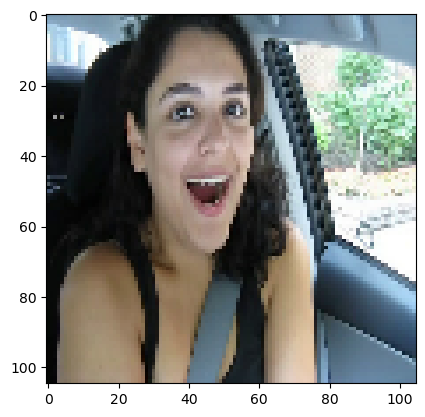

In [62]:
plt.imshow(testV[1])

In [64]:
y_act

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

# Eye Opening Detection

In [78]:
# eye paths 
eye_anchor = tf.data.Dataset.list_files(EYE_ANC_PATH+"\*.jpg").take(300)
eye_positive = tf.data.Dataset.list_files(EYE_POS_PATH+'\*.jpg').take(300)
eye_negative = tf.data.Dataset.list_files(EYE_NEG_PATH+'\*.jpg').take(300)

In [79]:
# Labelling of dataset
eye_positives = tf.data.Dataset.zip((eye_anchor, eye_positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(eye_positive)))))
eye_negatives = tf.data.Dataset.zip((eye_anchor, eye_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(eye_negative)))))
eye_data = eye_positives.concatenate(eye_negatives)

# Build dataloader pipeline
data = eye_data.map(read_preprocess_two_simul)
data = data.cache()
data = data.shuffle(buffer_size=1024)

## Train Test splitting
# Training partition
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [80]:
# Siam Model creation for eye classification 
siam = make_siamese()  

# Adam optimizer and Binary Cross entropy Optimization of parameters
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siam)


@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siam(X, training=True)
        loss = binary_cross_loss(y, yhat)

    grad = tape.gradient(loss, siam.trainable_variables)
    opt.apply_gradients(zip(grad, siam.trainable_variables))

    return loss


def train(data, EPOCHS):
    for epoch in range(0, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx + 0)

        if epoch % 4 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [81]:
train(train_data, 5)
siam.save('eye.keras')


 Epoch 0/5
17/27 [=================>............] - ETA: 2:22

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot batch tensors with different shapes in component 1. First element had shape [105,105,3] and element 10 had shape [105,105,4]. [Op:IteratorGetNext] name: 

In [46]:
model_eye = load_model('eye.keras', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [119]:
testA, testV, ya = test_data.as_numpy_iterator().next()

In [120]:
ya

array([0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [123]:
threshold_detection = 0.435
[0 if i < threshold_detection else 1 for i in model_yawn.predict([testA, testV])]

1/1 [==============================] - 1s 1s/step


[0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]

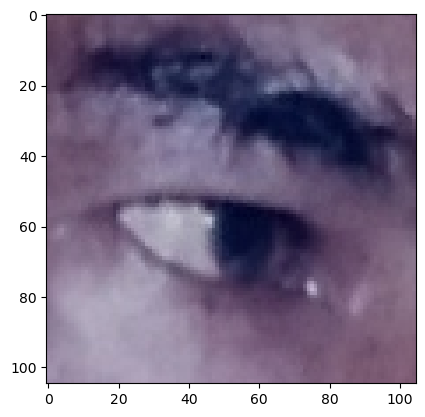

In [111]:
plt.imshow(testA[0])

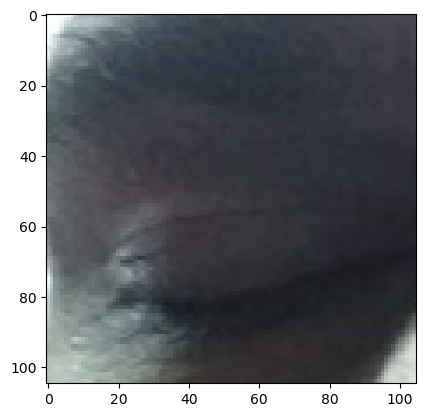

In [113]:
plt.imshow(testV[0])

# OpenCV Integration to detect drowsiness in real-time

In [167]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    cv2.imshow('Drowsiness Detector', frame)

    # Press c as in capture
    # to validate for drowsiness
    if cv2.waitKey(10) & 0xFF == ord('c'):
        cv2.imwrite(os.path.join('app_data', 'input_imgs', 'input_image.jpg'), frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [168]:
# Crop eye from the input_img
def get_eye(image):
    eye_cascade = cv2.CascadeClassifier(os.path.join('haarcascade', 'haarcascade_eye.xml'))
    eyes = eye_cascade.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(eyes):
        (x, y, w, h) = eyes[0]
        cropped_eye = image[y:y+h, x:x+w]
        resized_eye = cv2.resize(cropped_eye, (105, 105))
        # Preprocess the image for the model
        normalized_eye = resized_eye / 255.0
        input_data = normalized_eye.reshape(1, 105, 105, 3)

        return cropped_eye

    return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)


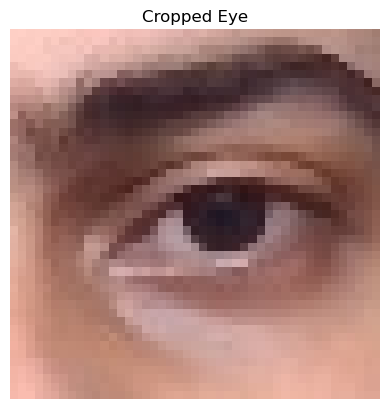

In [169]:
ce = get_eye(cv2.imread(os.path.join('app_data', 'input_imgs', 'input_image.jpg')))

plt.imshow(cv2.cvtColor(ce, cv2.COLOR_BGR2RGB))
plt.title("Cropped Eye")
plt.axis('off')
plt.show()


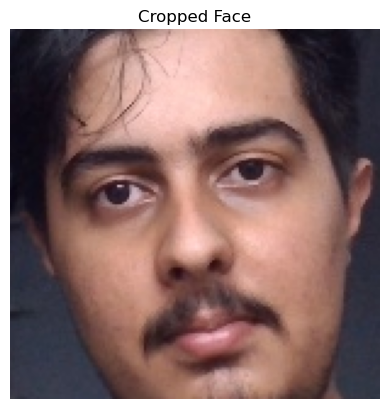

In [170]:
# Crop face from the input_img
def get_face(image):
    face_filter= cv2.CascadeClassifier(os.path.join('haarcascade', 'haarcascade_frontalface_default.xml'))
    faces = face_filter.detectMultiScale(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces):
        (x, y, w, h) = faces[0]
        cropped_face = image[y:y + h, x:x + w]
        resized_face = cv2.resize(cropped_face, (105, 105))
        # Preprocess the image for the model
        normalized_face = resized_face / 255.0
        input_data = normalized_face.reshape(1, 105, 105, 3)
        return cropped_face

    return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)


cf = get_face(cv2.imread(os.path.join('app_data', 'input_imgs', 'input_image.jpg')))

plt.imshow(cv2.cvtColor(cf, cv2.COLOR_BGR2RGB))
plt.title("Cropped Face")
plt.axis('off')
plt.show()

In [171]:
def drowsiness(model_eye, model_yawn):
    results_eye=[]
    for image in os.listdir(os.path.join('app_data', 'eye_det')):
        cv2.imwrite(os.path.join('app_data', 'input_imgs', 'crop_eye.jpg'), get_eye(cv2.imread(os.path.join('app_data', 'input_imgs', 'input_image.jpg'))))
        input_img = read_preprocess(os.path.join('app_data', 'input_imgs', 'crop_eye.jpg'))
        validation_img = read_preprocess(os.path.join('app_data', 'eye_det', image))
        result = model_eye.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results_eye.append(result)
        
    results_yawn=[]
    for image in os.listdir(os.path.join('app_data', 'yawn_det')):
        cv2.imwrite(os.path.join('app_data', 'input_imgs', 'crop_yawn.jpg'), get_face(cv2.imread(os.path.join('app_data', 'input_imgs', 'input_image.jpg'))))
        input_img = read_preprocess(os.path.join('app_data', 'input_imgs', 'crop_yawn.jpg'))
        validation_img = read_preprocess(os.path.join('app_data', 'yawn_det', image))
        result = model_yawn.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results_yawn.append(result)

    drowsiness_factor = 100 - (10*np.mean(np.array(results_eye)) + np.mean(np.array(results_yawn)))/6*100

    return drowsiness_factor

In [172]:
print(str(round(drowsiness(model_eye, model_yawn), 2))+'%')

1/1 [==============================] - 0s 317ms/step
26.84%
